In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pytorchvideo.data.encoded_video import EncodedVideo
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import sys

%run objects
%run models

In [5]:
train_dataset = ContactDataset(os.getcwd() + "/nfl-player-contact-detection/train_labels.csv",
                               ground=False, feature_size=256, num_back_forward_steps=1, 
                               skips=1, distance_cutoff=5, num_per_classification=1000)

Data Sample Contains 2000 observations.


In [6]:
train_dataset._cache_all_features

----Features being extracted for 230 plays and 2000 potential contacts-----
Play 1/230. (0 potential contact complete.)


100%|██████████| 34/34 [00:15<00:00,  2.16it/s]


Play 2/230. (34 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Play 3/230. (38 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Play 4/230. (46 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Play 5/230. (53 potential contact complete.)


100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Play 6/230. (64 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.10it/s]


Play 7/230. (73 potential contact complete.)


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


Play 8/230. (89 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Play 9/230. (93 potential contact complete.)


100%|██████████| 18/18 [00:08<00:00,  2.20it/s]


Play 10/230. (111 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Play 11/230. (117 potential contact complete.)


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Play 12/230. (133 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Play 13/230. (139 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


Play 14/230. (148 potential contact complete.)


100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


Play 15/230. (154 potential contact complete.)


100%|██████████| 17/17 [00:07<00:00,  2.23it/s]


Play 16/230. (171 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


Play 17/230. (180 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Play 18/230. (186 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Play 19/230. (196 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.15it/s]


Play 20/230. (205 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Play 21/230. (209 potential contact complete.)


100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Play 22/230. (229 potential contact complete.)


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Play 23/230. (243 potential contact complete.)


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


Play 24/230. (258 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Play 25/230. (263 potential contact complete.)


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Play 26/230. (280 potential contact complete.)


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Play 27/230. (297 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Play 28/230. (303 potential contact complete.)


100%|██████████| 11/11 [00:05<00:00,  2.18it/s]


Play 29/230. (314 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Play 30/230. (318 potential contact complete.)


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Play 31/230. (332 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.17it/s]


Play 32/230. (341 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


Play 33/230. (352 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Play 34/230. (356 potential contact complete.)


100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


Play 35/230. (365 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Play 36/230. (373 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Play 37/230. (381 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


Play 38/230. (392 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Play 39/230. (399 potential contact complete.)


100%|██████████| 25/25 [00:11<00:00,  2.26it/s]


Play 40/230. (424 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Play 41/230. (431 potential contact complete.)


100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Play 42/230. (443 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Play 43/230. (448 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Play 44/230. (458 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Play 45/230. (463 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Play 46/230. (471 potential contact complete.)


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Play 47/230. (484 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Play 48/230. (489 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Play 49/230. (499 potential contact complete.)


100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Play 50/230. (519 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Play 51/230. (526 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Play 52/230. (534 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Play 53/230. (539 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.23it/s]


Play 54/230. (550 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.21it/s]


Play 55/230. (559 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Play 56/230. (567 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Play 57/230. (574 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Play 58/230. (582 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Play 59/230. (592 potential contact complete.)


100%|██████████| 18/18 [00:07<00:00,  2.27it/s]


Play 60/230. (610 potential contact complete.)


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Play 61/230. (618 potential contact complete.)


100%|██████████| 18/18 [00:08<00:00,  2.17it/s]


Play 62/230. (636 potential contact complete.)


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Play 63/230. (651 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Play 64/230. (661 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Play 65/230. (671 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.21it/s]


Play 66/230. (680 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Play 67/230. (687 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


Play 68/230. (696 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.23it/s]


Play 69/230. (707 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


Play 70/230. (711 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Play 71/230. (714 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.17it/s]


Play 72/230. (723 potential contact complete.)


100%|██████████| 18/18 [00:08<00:00,  2.19it/s]


Play 73/230. (741 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Play 74/230. (751 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


Play 75/230. (760 potential contact complete.)


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Play 76/230. (776 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Play 77/230. (780 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Play 78/230. (785 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Play 79/230. (790 potential contact complete.)


100%|██████████| 19/19 [00:08<00:00,  2.25it/s]


Play 80/230. (809 potential contact complete.)


100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


Play 81/230. (820 potential contact complete.)


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Play 82/230. (828 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Play 83/230. (835 potential contact complete.)


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Play 84/230. (850 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


Play 85/230. (861 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Play 86/230. (866 potential contact complete.)


100%|██████████| 19/19 [00:08<00:00,  2.26it/s]


Play 87/230. (885 potential contact complete.)


100%|██████████| 46/46 [00:20<00:00,  2.24it/s]


Play 88/230. (931 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


Play 89/230. (942 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Play 90/230. (948 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Play 91/230. (954 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Play 92/230. (958 potential contact complete.)


100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Play 93/230. (970 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Play 94/230. (976 potential contact complete.)


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


Play 95/230. (989 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Play 96/230. (995 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Play 97/230. (1001 potential contact complete.)


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Play 98/230. (1015 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Play 99/230. (1025 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Play 100/230. (1030 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


Play 101/230. (1034 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Play 102/230. (1041 potential contact complete.)


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Play 103/230. (1054 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Play 104/230. (1064 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Play 105/230. (1069 potential contact complete.)


100%|██████████| 17/17 [00:07<00:00,  2.25it/s]


Play 106/230. (1086 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Play 107/230. (1092 potential contact complete.)


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Play 108/230. (1103 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Play 109/230. (1107 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Play 110/230. (1112 potential contact complete.)


100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Play 111/230. (1124 potential contact complete.)


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Play 112/230. (1139 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Play 113/230. (1149 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Play 114/230. (1153 potential contact complete.)


100%|██████████| 23/23 [00:10<00:00,  2.27it/s]


Play 115/230. (1176 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Play 116/230. (1183 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Play 117/230. (1189 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Play 118/230. (1194 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Play 119/230. (1197 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Play 120/230. (1204 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Play 121/230. (1212 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Play 122/230. (1220 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Play 123/230. (1228 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Play 124/230. (1234 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Play 125/230. (1241 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Play 126/230. (1249 potential contact complete.)


100%|██████████| 9/9 [00:03<00:00,  2.28it/s]


Play 127/230. (1258 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Play 128/230. (1261 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Play 129/230. (1269 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Play 130/230. (1276 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Play 131/230. (1283 potential contact complete.)


100%|██████████| 18/18 [00:08<00:00,  2.25it/s]


Play 132/230. (1301 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Play 133/230. (1307 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


Play 134/230. (1316 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Play 135/230. (1323 potential contact complete.)


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Play 136/230. (1336 potential contact complete.)


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


Play 137/230. (1349 potential contact complete.)


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Play 138/230. (1372 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Play 139/230. (1377 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Play 140/230. (1388 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.25it/s]


Play 141/230. (1397 potential contact complete.)


100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


Play 142/230. (1414 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Play 143/230. (1422 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Play 144/230. (1428 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Play 145/230. (1431 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Play 146/230. (1434 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Play 147/230. (1441 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


Play 148/230. (1450 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Play 149/230. (1458 potential contact complete.)


100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Play 150/230. (1470 potential contact complete.)


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Play 151/230. (1485 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Play 152/230. (1496 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Play 153/230. (1506 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Play 154/230. (1514 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Play 155/230. (1520 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Play 156/230. (1526 potential contact complete.)


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Play 157/230. (1527 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Play 158/230. (1531 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Play 159/230. (1539 potential contact complete.)


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Play 160/230. (1541 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Play 161/230. (1546 potential contact complete.)


100%|██████████| 18/18 [00:08<00:00,  2.24it/s]


Play 162/230. (1564 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


Play 163/230. (1575 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


Play 164/230. (1584 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Play 165/230. (1594 potential contact complete.)


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Play 166/230. (1606 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Play 167/230. (1612 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Play 168/230. (1617 potential contact complete.)


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Play 169/230. (1647 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Play 170/230. (1657 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Play 171/230. (1660 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Play 172/230. (1666 potential contact complete.)


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Play 173/230. (1668 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Play 174/230. (1672 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Play 175/230. (1680 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Play 176/230. (1683 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Play 177/230. (1690 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Play 178/230. (1695 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Play 179/230. (1702 potential contact complete.)


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Play 180/230. (1716 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Play 181/230. (1723 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Play 182/230. (1728 potential contact complete.)


100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Play 183/230. (1740 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Play 184/230. (1745 potential contact complete.)


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Play 185/230. (1757 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Play 186/230. (1764 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Play 187/230. (1767 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Play 188/230. (1771 potential contact complete.)


100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


Play 189/230. (1782 potential contact complete.)


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


Play 190/230. (1791 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Play 191/230. (1801 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Play 192/230. (1807 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Play 193/230. (1811 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


Play 194/230. (1814 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Play 195/230. (1821 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Play 196/230. (1829 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Play 197/230. (1835 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Play 198/230. (1841 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Play 199/230. (1849 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Play 200/230. (1855 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Play 201/230. (1861 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


Play 202/230. (1865 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Play 203/230. (1868 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Play 204/230. (1875 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Play 205/230. (1879 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Play 206/230. (1882 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


Play 207/230. (1885 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Play 208/230. (1890 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Play 209/230. (1895 potential contact complete.)


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Play 210/230. (1903 potential contact complete.)


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Play 211/230. (1909 potential contact complete.)


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Play 212/230. (1919 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Play 213/230. (1923 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Play 214/230. (1928 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Play 215/230. (1935 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Play 216/230. (1940 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Play 217/230. (1944 potential contact complete.)


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Play 218/230. (1946 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Play 219/230. (1950 potential contact complete.)


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


Play 220/230. (1952 potential contact complete.)


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Play 221/230. (1959 potential contact complete.)


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Play 222/230. (1961 potential contact complete.)


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


Play 223/230. (1963 potential contact complete.)


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Play 224/230. (1979 potential contact complete.)


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Play 225/230. (1982 potential contact complete.)


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


Play 226/230. (1984 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Play 227/230. (1989 potential contact complete.)


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Play 228/230. (1993 potential contact complete.)


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Play 229/230. (1998 potential contact complete.)


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Play 230/230. (1999 potential contact complete.)


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


tensor([1.])


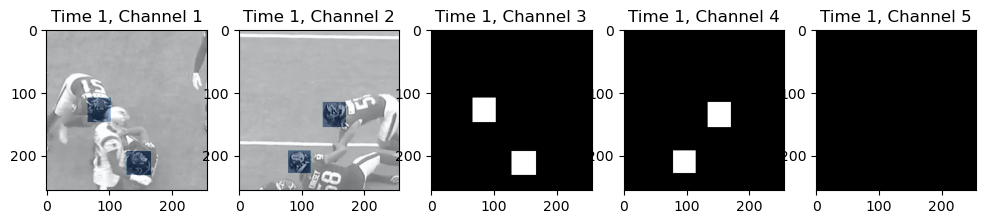

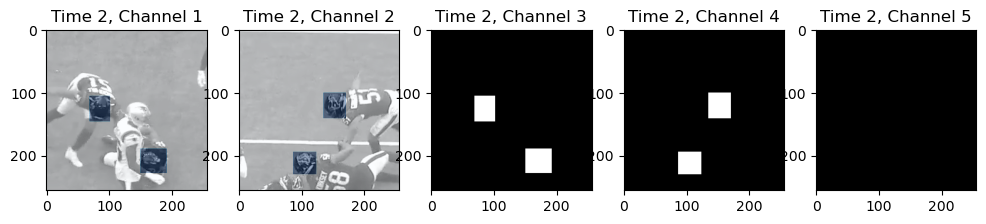

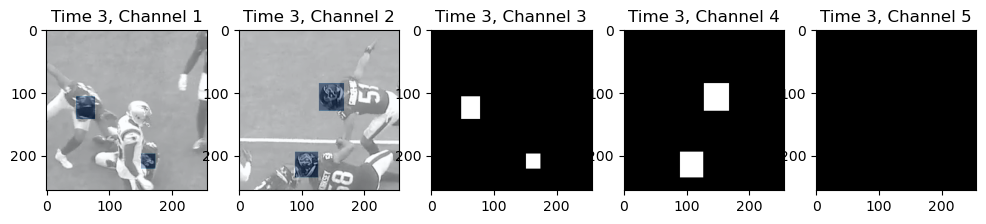

In [9]:
images=train_dataset[845]
j = 0
for image in images[0]:
    j+=1
    fig, axs = plt.subplots(1, 5, figsize=(12, 4)) 
    for i in range(5):
        channel = image[i, :, :]
        axs[i].imshow(channel, cmap='gray') 
        if i==0 or i==1:
            axs[i].imshow(image[i+2, :, :], alpha=0.4, cmap='Blues')  
        axs[i].set_title(f'Time {j}, Channel {i+1}')
print(images[1])

In [49]:
train_dataset[0][0][0].shape

torch.Size([5, 256, 256])

In [11]:
dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [12]:
image_size = 256
input_size = 100  # Output size of the Encoder's fully connected layer
hidden_size = 64
num_layers = 2
dropout = 0.1
learning_rate = 0.001
num_epochs = 10

In [13]:
combined_model = ContactNet(image_size, input_size, hidden_size, num_layers, dropout)
device = torch.device('cpu')
combined_model.to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(combined_model.parameters(), lr=learning_rate)

In [14]:
for epoch in range(num_epochs):
    # Training loop
    combined_model.train()
    for batch_idx, (features, labels) in enumerate(dataloader):
        x1, x2, x3 = features
        # Forward pass
        outputs = combined_model(x1, x2, x3)

        loss = criterion(outputs.squeeze(), labels.squeeze().float())  # Compute loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        # Print loss
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Batch [1/8], Loss: 0.6935
Epoch [1/10], Batch [2/8], Loss: 0.6927
Epoch [1/10], Batch [3/8], Loss: 0.6914
Epoch [1/10], Batch [4/8], Loss: 0.6909
Epoch [1/10], Batch [5/8], Loss: 0.6894
Epoch [1/10], Batch [6/8], Loss: 0.6882
Epoch [1/10], Batch [7/8], Loss: 0.6885
Epoch [1/10], Batch [8/8], Loss: 0.6865
Epoch [2/10], Batch [1/8], Loss: 0.6843
Epoch [2/10], Batch [2/8], Loss: 0.6799
Epoch [2/10], Batch [3/8], Loss: 0.6743
Epoch [2/10], Batch [4/8], Loss: 0.6753
Epoch [2/10], Batch [5/8], Loss: 0.6702
Epoch [2/10], Batch [6/8], Loss: 0.6660
Epoch [2/10], Batch [7/8], Loss: 0.6640
Epoch [2/10], Batch [8/8], Loss: 0.6611
Epoch [3/10], Batch [1/8], Loss: 0.6393
Epoch [3/10], Batch [2/8], Loss: 0.6230
Epoch [3/10], Batch [3/8], Loss: 0.6398
Epoch [3/10], Batch [4/8], Loss: 0.6228
Epoch [3/10], Batch [5/8], Loss: 0.6231
Epoch [3/10], Batch [6/8], Loss: 0.6011
Epoch [3/10], Batch [7/8], Loss: 0.5844
Epoch [3/10], Batch [8/8], Loss: 0.5815
Epoch [4/10], Batch [1/8], Loss: 0.5431


In [34]:
test_dataset = ContactDataset(os.getcwd() + "/nfl-player-contact-detection/test_labels.csv",
                               ground=False, feature_size=256, num_back_forward_steps=1, 
                               skips=1, distance_cutoff=5, num_per_classification=1000)
test_dataset._cache_all_features

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11T03:01:48.100Z,0,38590,43854,0
11798,58168_003392_46_37084_46522,58168_003392,2020-09-11T03:01:52.700Z,46,37084,46522,0
11799,58168_003392_46_44869_47944,58168_003392,2020-09-11T03:01:52.700Z,46,44869,47944,0
11800,58168_003392_46_44869_47837,58168_003392,2020-09-11T03:01:52.700Z,46,44869,47837,0
11801,58168_003392_46_44869_46137,58168_003392,2020-09-11T03:01:52.700Z,46,44869,46137,0
...,...,...,...,...,...,...,...
4706095,58582_003121_30_46105_46121,58582_003121,2021-10-12T02:42:23.000Z,30,46105,46121,0
4706094,58582_003121_30_46105_52609,58582_003121,2021-10-12T02:42:23.000Z,30,46105,52609,0
4706093,58582_003121_30_45287_52619,58582_003121,2021-10-12T02:42:23.000Z,30,45287,52619,0
4706091,58582_003121_30_45287_47906,58582_003121,2021-10-12T02:42:23.000Z,30,45287,47906,0


(711, 720, 1280)

In [97]:
train_info = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_labels.csv")
train_info

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11T03:01:48.100Z,0,38590,43854,0
1,58168_003392_0_38590_41257,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41257,0
2,58168_003392_0_38590_41944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41944,0
3,58168_003392_0_38590_42386,58168_003392,2020-09-11T03:01:48.100Z,0,38590,42386,0
4,58168_003392_0_38590_47944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,47944,0
...,...,...,...,...,...,...,...
4721613,58582_003121_91_48220_G,58582_003121,2021-10-12T02:42:29.100Z,91,48220,G,0
4721614,58582_003121_91_47906_G,58582_003121,2021-10-12T02:42:29.100Z,91,47906,G,0
4721615,58582_003121_91_38557_G,58582_003121,2021-10-12T02:42:29.100Z,91,38557,G,0
4721616,58582_003121_91_47872_G,58582_003121,2021-10-12T02:42:29.100Z,91,47872,G,0


In [14]:
helmet = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_baseline_helmets.csv")
train_info = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_labels.csv")
tracking = pd.read_csv("/Users/nickbachelder/Desktop/Personal Code/Kaggle/Contact/nfl-player-contact-detection/train_player_tracking.csv")
train_info['frame'] = list(map(step_to_frame, train_info.step))

In [85]:
train_info.loc[train_info.contact==1]

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,frame
809,58168_003392_3_41944_42565,58168_003392,2020-09-11T03:01:48.400Z,3,41944,42565,1,317
1062,58168_003392_4_41944_42565,58168_003392,2020-09-11T03:01:48.500Z,4,41944,42565,1,323
1163,58168_003392_4_37084_38567,58168_003392,2020-09-11T03:01:48.500Z,4,37084,38567,1,323
1289,58168_003392_5_43854_46445,58168_003392,2020-09-11T03:01:48.600Z,5,43854,46445,1,329
1315,58168_003392_5_41944_42565,58168_003392,2020-09-11T03:01:48.600Z,5,41944,42565,1,329
...,...,...,...,...,...,...,...,...
4720589,58582_003121_87_39971_G,58582_003121,2021-10-12T02:42:28.700Z,87,39971,G,1,821
4720842,58582_003121_88_39971_G,58582_003121,2021-10-12T02:42:28.800Z,88,39971,G,1,827
4721095,58582_003121_89_39971_G,58582_003121,2021-10-12T02:42:28.900Z,89,39971,G,1,833
4721348,58582_003121_90_39971_G,58582_003121,2021-10-12T02:42:29.000Z,90,39971,G,1,839


In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pytorchvideo.data.encoded_video import EncodedVideo
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
from objects import step_to_frame, create_boxes_dict, ContactDataset
from models import Encoder, LSTMModel, ContactNet
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")  # Use CPU
    print("CUDA is not available. Using CPU.")

print("---Loading Train Dataloader----")
dataset = ContactDataset(os.getcwd() + "/nfl-player-contact-detection/train_labels.csv",
                      ground=False, feature_size=256, num_back_forward_steps=1, skips=1, distance_cutoff=5, num_per_classification=10)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

image_size = 128
input_size = 100  # Output size of the Encoder's fully connected layer
hidden_size = 64
num_layers = 2
dropout = 0.1
learning_rate = 0.001
num_epochs = 10

print("---Initializing Model----")
combined_model = ContactNet(image_size, input_size, hidden_size, num_layers, dropout)
combined_model.to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(combined_model.parameters(), lr=learning_rate)


print("---Training----")
for epoch in range(num_epochs):
    # Training loop
    combined_model.train()
    print(f"---Epoch {epoch}----")
    for batch_idx, (features, labels) in enumerate(dataloader):
        print(f"Batch {batch_idx}")
        x1, x2, x3, x4, x5 = features
        x1, x2, x3, x4, x5, labels = x1.to(device), x2.to(device), x3.to(device), x4.to(device), x5.to(device), labels.to(device)
        # Forward pass
        outputs = combined_model(x1, x2, x3, x4, x5)
        loss = criterion(outputs.squeeze(), labels.float())  # Compute loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

/Users/nickbachelder/opt/anaconda3/envs/data-science/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is not available. Using CPU.
---Loading Train Dataloader----
Data Sample Contains 20 observations.
---Initializing Model----
---Training----
---Epoch 0----
Batch 0


ValueError: not enough values to unpack (expected 5, got 3)